# [Lecture 17 - Measurement & Misclassification](https://www.youtube.com/watch?v=mt9WKbQJrI4)

In [1]:
%run init_notebook.py

Module aliases imported by init_notebook.py:
--------------------------------------------
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import pymc as pm
import xarray as xr
import arviz as az
from scipy import stats as stats
import utils as utils
from functools import partial as partial
from matplotlib import pyplot as plt
from typing import List, as Optional,
Watermark:
----------
Last updated: 2024-06-29T17:33:27.078376+09:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.25.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 6.6.25-01713-g2f237acc8e50
Machine     : x86_64
Processor   : 
CPU cores   : 4
Architecture: 64bit

pandas     : 2.2.2
statsmodels: 0.14.2
pymc       : 5.15.1
numpy      : 1.26.4
xarray     : 2024.6.0
arviz      : 0.18.0
scipy      : 1.13.1
matplotlib : 3.8.4



In [2]:
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np
import networkx as nx
from scipy import stats as stats

# Probability, Intuition, and Pancakes 🥞

McElreath poses a re-dressing of the [classic Monty Hall Problem](https://en.wikipedia.org/wiki/Monty_Hall_problem). The original problem uses an old gameshow called "Let's Make a Deal" (hosted by Monty Hall) as the backdrop for a scenario where the correct, optimal strategy for winning a game is given by following the rules of probability theory. What's interesting about the Monty Hall problem is that the optimal strategy doesn't align with our intuitions.

In lecure, instead of opening doors to find donkeys or prizes, as was in the case of the Monty Hall problem, we have pancakes that are either burnt or perfectly cooked on either side. The thought experiment goes like this:

- You have 3 pancakes:
  - One (likely the first one you cooked) is burnt on both sides
  - One (likely the next one cooked, after you're improving your cooking skills) is burnt on only one side
  - One is cooked perfectly on both sides
- Say you are given a pancake at random and it is burned on one side
- What is the probability that the other side is burned?

Most folks would say 1/2, which intuitively _feels_ correct. However, the correct answer is given by Bayes rule:

If we define $U, D$ as observing upside $U$ or downsid $D$ hot being burnt and $U', D'$ as up or down sides being burnt

$$
\begin{align*}
p(D' | U') &= \frac{p(U', D')}{p(U')} &\text{Bayes Rule} \\
p(U', D') &= 1/3 &\text{only one out of three pancakes has both sides burnt} \\
p(U') &= (1/3 \times 2/2)  + (1/3 \times 1/2) + (1/3 \times 0) = 3/6 = 1/2 &\text{probability of initially observing upside burnt} \\
p(D' | U') &= \frac{1/3}{1/2} = 2/3
\end{align*}
$$

## Avoid being clever

- Being clever is unreliable
- Being clever is opaque
- You'll rarely beat the axioms of probability theory
- Probability allows us to solve complex problems, if we stick to the rules


# Measurement Error

- Many variables are proxies for what we want to measure (e.g. Descendant elemental confound)
- It's common practice to ignore measurement error
  - assumes error is harmless, or will "average out"
- Better to draw out the measurement error, think causally, and fall back on probability theory (don't be clever)

## Myth: Measurement error can only decrease an effect, not increase

- This is incorrect, measurement error has no predefined direction of causal effect
- It can, in some cases, _increase_ an effect, as we'll demonstrate below

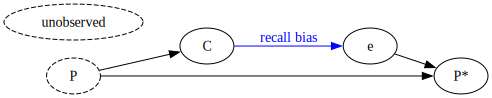

In [2]:
utils.draw_causal_graph(
    edge_list=[
        ("P", "C"),
        ("P", "P*"),
        ("e", "P*"),
        ("C", "e")
    ],
    node_props={
        "P": {"style": "dashed"},
        "unobserved": {"style": "dashed"},
    },
    edge_props={
        ("C", "e"): {"label": "recall bias", "color": "blue", "fontcolor": "blue"}
    },
    graph_direction="LR"
)

- Child Income $C$
- Actual Parental Income $P$, unobserved
- Measured parental income $P^*$
- Error in Parental income reporting $P^*$ (e.g. due to recall bias)

In [3]:
def simulate_child_parent_income(beta_P=0, n_samples=500, title=None, random_seed=123):
    np.random.seed(random_seed)
    P = stats.norm().rvs(size=n_samples)
    C = stats.norm.rvs(beta_P * P)
    mu_P_star = 0.8 * P + 0.2 * C
    P_star = stats.norm.rvs(mu_P_star)

    with pm.Model() as model:
        sigma = pm.Exponential("sigma", 1)
        beta = pm.Normal("beta", 0, 1)
        alpha = pm.Normal("alpha", 0, 1)
        mu = alpha + beta * P_star
        pm.Normal("C", mu, sigma, observed=C)
        inference = pm.sample(tune=1000,
                                   draws=1000,
                                   chains=4,
                                   nuts_sampler='numpyro',
                                   target_accept=.8)

    az.plot_dist(inference.posterior['beta'])
    plt.axvline(beta_P, color='k', linestyle='--', label="actual")
    plt.title(title)
    plt.legend()
    
    return az.summary(inference, var_names=["alpha", "beta", "sigma"])

In [4]:
def simulate_child_parent_income(beta_P: float = 0, n_samples: int = 500, title: str = None, random_seed: int = 123) -> az.data.inference_data.InferenceData:
    """
    Simulate child-parent income relationship and perform Bayesian inference on the model parameters.

    Parameters:
    beta_P (float): The true coefficient relating parent income to child income.
    n_samples (int): Number of samples to generate.
    title (str): Title for the plot.
    random_seed (int): Random seed for reproducibility.

    Returns:
    az.data.inference_data.InferenceData: Summary of the posterior distribution of the model parameters.
    """
    # Set random seed for reproducibility
    np.random.seed(random_seed)

    # Generate parent and child income samples
    P = stats.norm().rvs(size=n_samples)
    C = stats.norm.rvs(beta_P * P)
    mu_P_star = 0.8 * P + 0.2 * C
    P_star = stats.norm.rvs(mu_P_star)

    # Define and sample from the Bayesian model
    with pm.Model() as model:
        sigma = pm.Exponential("sigma", 1)
        beta = pm.Normal("beta", 0, 1)
        alpha = pm.Normal("alpha", 0, 1)
        mu = alpha + beta * P_star
        pm.Normal("C", mu, sigma, observed=C)
        inference = pm.sample(tune=1000,
                                   draws=1000,
                                   chains=4,
                                   nuts_sampler='numpyro',
                                   target_accept=.8)

    # Plot the posterior distribution of beta
    az.plot_dist(inference.posterior['beta'])
    plt.axvline(beta_P, color='k', linestyle='--', label="actual")
    if title:
        plt.title(title)
    plt.legend()

    # Return summary of the inference
    return az.summary(inference, var_names=["alpha", "beta", "sigma"])

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.043,0.044,-0.122,0.041,0.001,0.001,4327.0,2847.0,1.0
beta,0.166,0.038,0.097,0.237,0.001,0.000,3814.0,2708.0,1.0
sigma,0.983,0.031,0.928,1.043,0.000,0.000,4062.0,2918.0,1.0


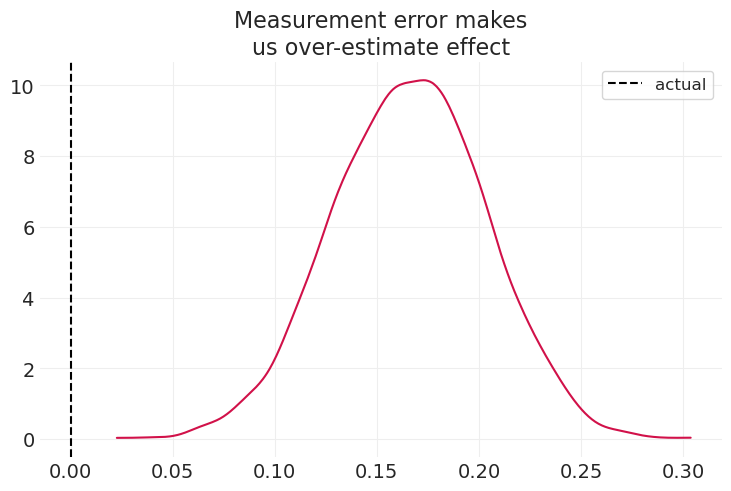

In [5]:
simulate_child_parent_income(title="Measurement error makes\nus over-estimate effect")

In the scenario above, measurement error can cause us over-estimate the actual effect

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.077,0.047,-0.164,0.009,0.001,0.001,4278.0,2808.0,1.0
beta,0.542,0.037,0.470,0.608,0.001,0.000,4331.0,2617.0,1.0
sigma,1.051,0.033,0.989,1.113,0.000,0.000,4616.0,2880.0,1.0


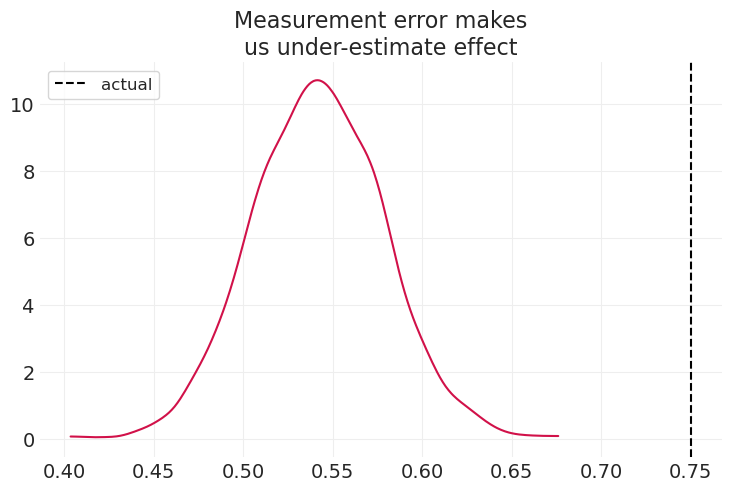

In [6]:
simulate_child_parent_income(beta_P=0.75, title="Measurement error makes\nus under-estimate effect")

In the scenario above, measurement error can cause us under-estimate the actual effect

- What happens depends on the details of the context
- **There is no general rule to tell you what measurement error will do to your estimate**

# Modeling Measurment

## Revisiting the Wafflehouse Divorce Dataset

In [7]:
WAFFLE_DIVORCE = utils.load_data("WaffleDivorce")
WAFFLE_DIVORCE.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


### Problems
- Imbalance in evidence
- Potential confounding
  - e.g. population size

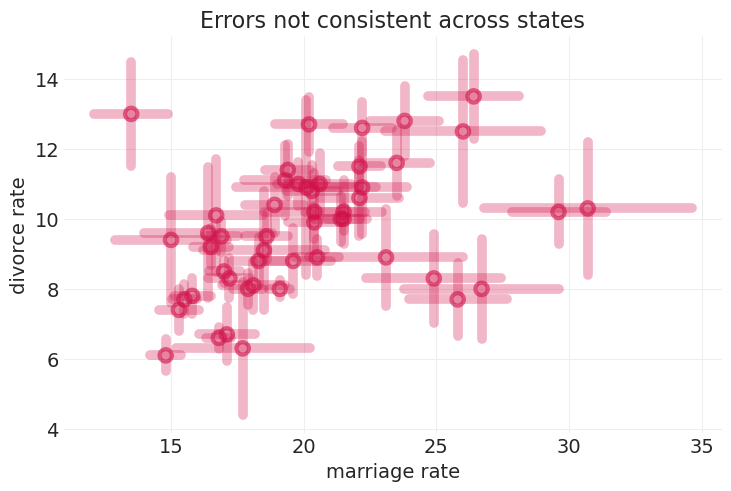

In [8]:
utils.plot_scatter(
    WAFFLE_DIVORCE.Marriage,
    WAFFLE_DIVORCE.Divorce,
    label=None
)

utils.plot_errorbar(
    xs=WAFFLE_DIVORCE.Marriage,
    ys=WAFFLE_DIVORCE.Divorce,
    error_lower=WAFFLE_DIVORCE['Divorce SE'],
    error_upper=WAFFLE_DIVORCE['Divorce SE'],
    error_width=7
)

utils.plot_x_errorbar(
    xs=WAFFLE_DIVORCE.Marriage,
    ys=WAFFLE_DIVORCE.Divorce,
    error_lower=WAFFLE_DIVORCE['Marriage SE'],
    error_upper=WAFFLE_DIVORCE['Marriage SE'],
    error_width=7
)
    
plt.xlabel("marriage rate")
plt.ylabel("divorce rate")
plt.title("Errors not consistent across states");

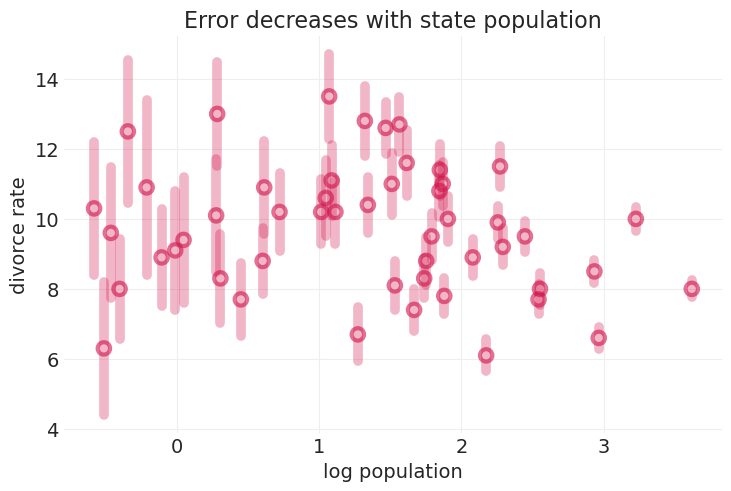

In [9]:
utils.plot_scatter(
    np.log(WAFFLE_DIVORCE.Population),
    WAFFLE_DIVORCE.Divorce,
    label=None
)

utils.plot_errorbar(
    xs=np.log(WAFFLE_DIVORCE.Population),
    ys=WAFFLE_DIVORCE.Divorce,
    error_lower=WAFFLE_DIVORCE['Divorce SE'],
    error_upper=WAFFLE_DIVORCE['Divorce SE'],
    error_width=7
)
plt.xlabel("log population")
plt.ylabel("divorce rate")
plt.title("Error decreases with state population");

## Measured divorce model

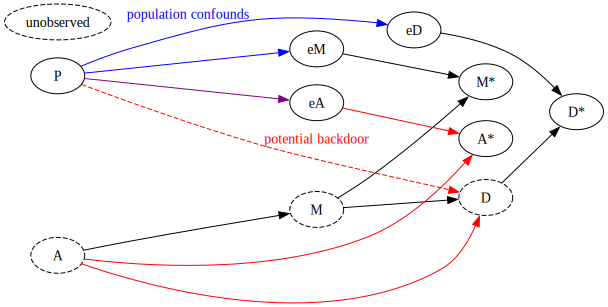

In [9]:
utils.draw_causal_graph(
    edge_list=[
        ("M", "D"),
        ("A", "M"),
        ("A", "D"),
        ("M", "M*"),
        ("D", "D*"),
        ("eD", "D*"),
        ("eM", "M*"),
        ("A", "A*"),
        ("eA", "A*"),
        ("P", "eA"),
        ("P", "eM"),
        ("P", "eD"),
        ("P", "D")
    ],
    node_props={
        "unobserved": {"style": "dashed"},
        "A": {"style": "dashed"},
        "M": {"style": "dashed"},
        "D": {"style": "dashed"},
    },
    edge_props={
        ("P", "eA"): {"color": "blue"},
        ("P", "eM"): {"color": "blue"},
        ("P", "eD"): {"color": "blue", "label": "population confounds", "fontcolor": "blue"},
        ("P", "D"): {"style": "dashed", "label": " potential backdoor", "color": "red", "fontcolor": "red"},
        ("A", "A*"): {"color": "red"},
        ("P", "eA"): {"color": "purple"},
        ("eA", "A*"): {"color": "red"},
        ("A", "D"): {"color": "red"},
    },
    graph_direction="LR"
)

## Thinking like a graph

- **Thinking like regression**: which _predictors_ do I include in the model?
  - stop doing this
  - To be fair, GLMs enable this approach
  - The scientific world is SO MUCH LARGER than GLMs (e.g. think about the difference equation in tool use example)
- **Thinking like a graph**:how do I model the network of _causes_?
  - e.g. Full Luxury Bayes
 
## Let's start simpler

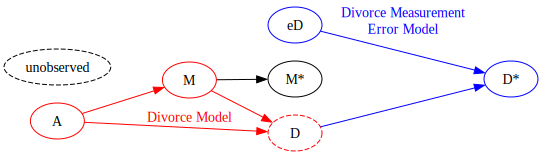

In [10]:
utils.draw_causal_graph(
    edge_list=[
        ("M", "D"),
        ("A", "M"),
        ("A", "D"),
        ("M", "M*"),
        ("D", "D*"),
        ("eD", "D*")
    ],
    node_props={
        "unobserved": {"style": "dashed"},
        "D": {"style": "dashed", "color": "red"},
        "M": {"color": "red"},
        "A": {"color": "red"},
        "eD": {"color": "blue"},
        "D*": {"color": "blue"},
    },
    edge_props={
        ("A", "M"): {"color": "red"},
        ("A", "D"): {"color": "red", "label": "Divorce Model", "fontcolor": "red"},
        ("M", "D"): {"color": "red"},
        ("eD", "D*"): {"color": "blue", "label": " Divorce Measurement\nError Model", "fontcolor": "blue"},
        ("D", "D*"): {"color": "blue"}
    },
    graph_direction="LR"
)

### 2 submodels

#### <span style="color:red">Divorce Model</span>

$$
\begin{align*}
D_i &\sim \text{Normal}(\mu_i) \\
\mu_i &= \alpha + \beta_A A + \beta_M M
\end{align*}
$$


#### <span style="color:blue">Divorce Measurement Error Model</span>
$$
\begin{align*}
D^*_i &= D_i + e_D \\
e_{D,i} &\sim \text{Normal}(0, S_i) &S_i \text{ is the standard deviation estimated from the sample}
\end{align*}
$$


### Fit the Divorce Measurement Error Model

- two simultaneous regressions
  - One for $D$
    - Note: these are just parameters in the model, they are not observed 🤯
  - One for $D*$

In [32]:
# data preparation
DIVORCE_STD = WAFFLE_DIVORCE['Divorce'].std()
DIVORCE = utils.standardize(WAFFLE_DIVORCE['Divorce']).values
MARRIAGE = utils.standardize(WAFFLE_DIVORCE['Marriage']).values
AGE = utils.standardize(WAFFLE_DIVORCE['MedianAgeMarriage']).values
DIVORCE_SE = WAFFLE_DIVORCE['Divorce SE'].values / DIVORCE_STD
STATE_ID, STATE = pd.factorize(WAFFLE_DIVORCE['Loc'])
N = len(WAFFLE_DIVORCE)
MARRIAGE_STD = WAFFLE_DIVORCE['Marriage'].std()
MARRIAGE_SE = WAFFLE_DIVORCE['Marriage SE'].values / MARRIAGE_STD

# Define coordinates for the model
coords = {'state': STATE}

In [27]:
with pm.Model(coords=coords) as measured_divorce_model:
    # Priors for the standard deviation, intercept, and coefficients
    sigma = pm.Exponential("sigma", 1)  # Standard deviation of the divorce rate
    alpha = pm.Normal("alpha", 0, 0.2)  # Intercept for the mean divorce rate
    beta_A = pm.Normal("beta_A", 0, 0.5)  # Coefficient for the effect of AGE
    beta_M = pm.Normal("beta_M", 0, 0.5)  # Coefficient for the effect of MARRIAGE

    # Likelihood: Mean divorce rate as a linear combination of AGE and MARRIAGE
    mu = alpha + beta_A * AGE + beta_M * MARRIAGE

    # Latent (true) divorce rate for each state
    D = pm.Normal("D", mu, sigma, dims='state')

    # Observed divorce rate with measurement error
    pm.Normal("D_obs", D, DIVORCE_SE, observed=DIVORCE, dims='state')

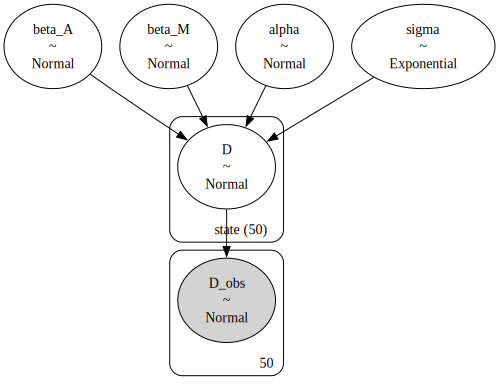

In [28]:
pm.model_to_graphviz(measured_divorce_model)

In [29]:
with measured_divorce_model:    
    measured_divorce_inference = pm.sample(tune=1000,
                                   draws=1000,
                                   chains=4,
                                   nuts_sampler='numpyro',
                                   target_accept=.8)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

#### Posterior for True Divorce Rates

In [30]:
az.summary(measured_divorce_inference, var_names=["D"])[:10]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
D[AL],1.185,0.361,0.484,1.850,0.005,0.003,5549.0,2685.0,1.0
D[AK],0.691,0.549,-0.347,1.699,0.007,0.007,6492.0,2850.0,1.0
D[AZ],0.432,0.347,-0.199,1.080,0.004,0.004,8066.0,2605.0,1.0
D[AR],1.425,0.465,0.579,2.325,0.005,0.004,7793.0,2947.0,1.0
D[CA],-0.911,0.126,-1.137,-0.669,0.001,0.001,8832.0,2641.0,1.0
D[CO],0.664,0.391,-0.069,1.382,0.005,0.004,7207.0,3215.0,1.0
D[CT],-1.391,0.351,-2.029,-0.698,0.004,0.003,8735.0,2660.0,1.0
D[DE],-0.349,0.482,-1.312,0.540,0.005,0.007,8332.0,2872.0,1.0
D[DC],-1.913,0.615,-3.093,-0.794,0.009,0.006,5043.0,3158.0,1.0
D[FL],-0.626,0.170,-0.943,-0.322,0.002,0.001,8955.0,2588.0,1.0


#### The effect of modeling the Divorce measurment error

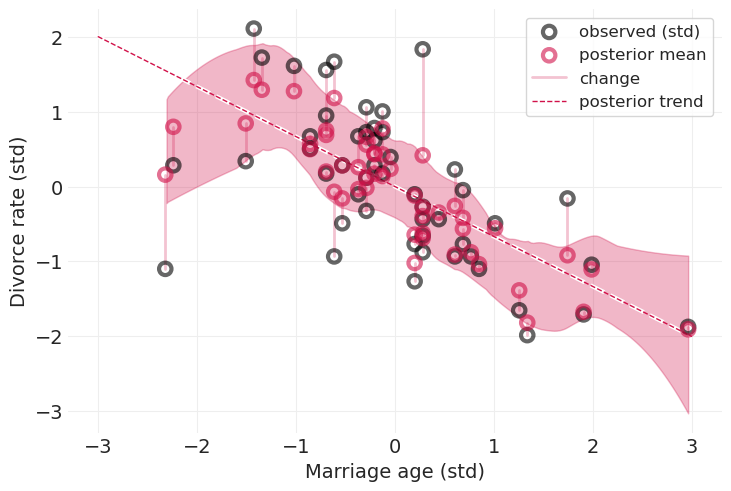

In [31]:
def plot_change_xy(x_orig, y_orig, x_new, y_new, color='C0'):
    """
    Plot lines showing changes from original to new points.

    Parameters:
    x_orig, y_orig : array-like
        Original x and y coordinates.
    x_new, y_new : array-like
        New x and y coordinates after some change.
    color : str
        Color of the lines.
    """
    for ii, (xo, yo, xn, yn) in enumerate(zip(x_orig, y_orig, x_new, y_new)):
        label = 'change' if not ii else None
        plt.plot((xo, xn), (yo, yn), linewidth=2, alpha=.25, color=color, label=label)

# Compute the posterior mean of the true divorce rate
D_true = measured_divorce_inference.posterior.mean(dim=('chain', 'draw'))['D'].values

# Plot raw observations
utils.plot_scatter(
    AGE,
    DIVORCE,
    color='k',
    label='observed (std)',
    zorder=100
)

# Plot divorce posterior mean
utils.plot_scatter(
    AGE,
    D_true,
    color='C0',
    label='posterior mean',
    zorder=100
)

# Plot changes from observed to posterior mean
plot_change_xy(AGE, DIVORCE, AGE, D_true)

# Compute the trend slope using least squares
trend_slope = np.linalg.lstsq(AGE[:, None], D_true, rcond=None)[0]

# Generate x values for the trendline
xs = np.linspace(-3, 3, 100)
# Compute corresponding y values for the trendline
ys = xs * trend_slope
utils.plot_line(
    xs=xs,
    ys=ys,
    linestyle='--',
    color='C0',
    label='posterior trend',
    linewidth=1
)

# Plot the highest density interval (HDI) at 89% for the posterior mean
# az.plot_hdi(AGE, measured_divorce_inference.posterior['D'], hdi_prob=0.89, color='C0', fill_kwargs={'alpha': 0.3})

plt.xlabel("Marriage age (std)")
plt.ylabel("Divorce rate (std)")
plt.legend()

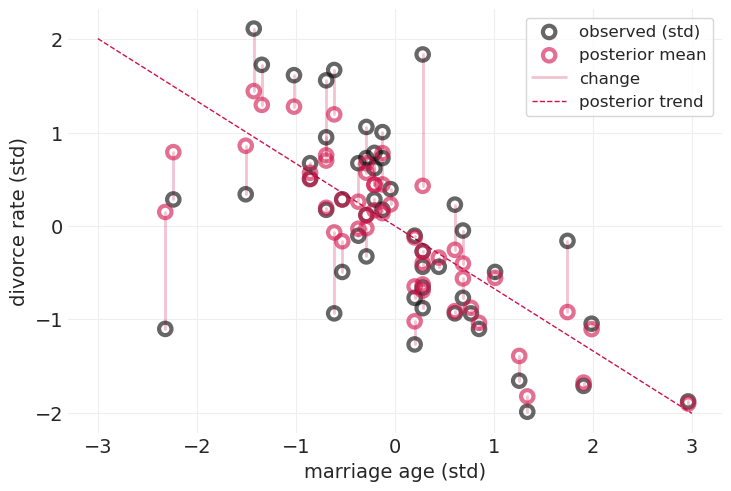

In [22]:
def plot_change_xy(x_orig, y_orig, x_new, y_new, color='C0'):
    for ii, (xo, yo, xn, yn) in enumerate(zip(x_orig, y_orig, x_new, y_new)):
        label = 'change' if not ii else None
        plt.plot((xo, xn), (yo, yn), linewidth=2, alpha=.25, color=color, label=label)

D_true = measured_divorce_inference.posterior.mean(dim=('chain', 'draw'))['D'].values

# Plot raw observations
utils.plot_scatter(
    AGE,
    DIVORCE,
    color='k',
    label='observed (std)',
    zorder=100
)

# Plot divorce posterior
utils.plot_scatter(
    AGE,
    D_true,
    color='C0',
    label='posterior mean',
    zorder=100
)

plot_change_xy(AGE, DIVORCE, AGE, D_true)

# Add trendline
# AGE and DIVORCE are standardized, so no need for offset
trend_slope = np.linalg.lstsq(AGE[:, None], D_true)[0]
xs = np.linspace(-3, 3, 10)
ys = xs * trend_slope
utils.plot_line(
    xs=xs,
    ys=ys,
    linestyle='--',
    color='C0',
    label='posterior trend',
    linewidth=1
)

plt.xlabel("marriage age (std)")
plt.ylabel("divorce rate (std)")
plt.legend()

- black points ignore measurement error
- red points are posterior means for model that captures measurement error in Divorcd rates
- thin pink lines demonstrate the movement of estimates by modeling measurment error
- Modeling measurement error in divorce rates shrinks estimates for states more uncertainty (larger standard errors) toward the main trend line (dashed red line)
  - partial pooling information across states
- **You get this all for free by drawing the graph, and following the rules of probablity**

### Divorce and Marriage Measurement Error Model

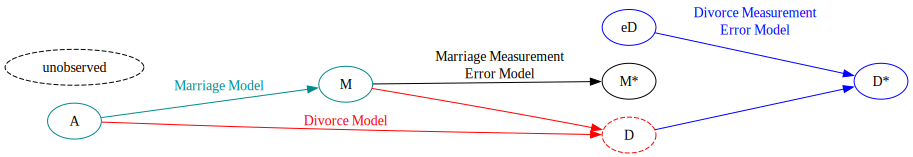

In [26]:
utils.draw_causal_graph(
    edge_list=[
        ("M", "D"),
        ("A", "M"),
        ("A", "D"),
        ("M", "M*"),
        ("D", "D*"),
        ("eD", "D*")
    ],
    node_props={
        "unobserved": {"style": "dashed"},
        "D": {"style": "dashed", "color": "red"},
        "M": {"color": "darkcyan"},
        "A": {"color": "darkcyan"},
        "eD": {"color": "blue"},
        "D*": {"color": "blue"},
    },
    edge_props={
        ("A", "M"): {"color": "darkcyan", "label": "Marriage Model", "fontcolor": "darkcyan"},
        ("A", "D"): {"color": "red", "label": "Divorce Model", "fontcolor": "red"},
        ("M", "D"): {"color": "red"},
        ("M", "M*"): {"label": "Marriage Measurement\nError Model"},
        ("eD", "D*"): {"color": "blue", "label": " Divorce Measurement\nError Model", "fontcolor": "blue"},
        ("D", "D*"): {"color": "blue"}
    },
    graph_direction="LR"
)

### 4 Submodels

#### <span style="color:red">Divorce Model</span>

$$
\begin{align*}
D_i &\sim \text{Normal}(\mu_{Di}, \sigma_D) \\
\mu_{Di} &= \alpha_D + \beta_{AD} A_i + \beta_{MD} M_i
\end{align*}
$$


#### <span style="color:blue">Divorce Measurement Error Model</span>
$$
\begin{align*}
D^*_i &= D_i + e_D \\
e_{D,i} &\sim \text{Normal}(0, S_{Di}) &S_{Di} \text{ is the divorce standard deviation estimated from the sample}
\end{align*}
$$

#### <span style="color:darkcyan">Marriage Rate Model</span>
$$
\begin{align*}
M_i &\sim \text{Normal}(\mu_{Mi}, \sigma_M) \\
\mu_{Mi} &= \alpha_M + \beta_{AM} A_i
\end{align*}
$$

#### Marriage Rate Measurement Error Model
$$
\begin{align*}
M^*_i &= M_i + e_M \\
e_{M,i} &\sim \text{Normal}(0, S_{Mi}) &S_{Mi} \text{ is the marriage standard deviation estimated from the sample}
\end{align*}
$$


In [33]:
# Define coordinates for the model
coords = {'state': STATE}

with pm.Model(coords=coords) as measured_divorce_marriage_model:
    # Marriage Model
    # Priors for marriage model
    sigma_marriage = pm.Exponential("sigma_M", 1)  # Standard deviation of the marriage rate
    alpha_marriage = pm.Normal("alpha_M", 0, 0.2)  # Intercept for the mean marriage rate
    beta_AM = pm.Normal("beta_AM", 0, 0.5)  # Coefficient for the effect of AGE on marriage rate

    # True marriage parameter (latent variable)
    mu_marriage = alpha_marriage + beta_AM * AGE  # Linear model for marriage rate
    M = pm.Normal("M", mu_marriage, sigma_marriage, dims='state')  # Latent marriage rate

    # Observed marriage rate with measurement error
    pm.Normal("M_obs", M, MARRIAGE_SE, observed=MARRIAGE, dims='state')

    # Divorce Model
    # Priors for divorce model
    sigma_divorce = pm.Exponential("sigma_D", 1)  # Standard deviation of the divorce rate
    alpha_divorce = pm.Normal("alpha_D", 0, 0.2)  # Intercept for the mean divorce rate
    beta_AD = pm.Normal("beta_AD", 0, 0.5)  # Coefficient for the effect of AGE on divorce rate
    beta_MD = pm.Normal("beta_MD", 0, 0.5)  # Coefficient for the effect of M on divorce rate

    # True divorce parameter (latent variable)
    mu_divorce = alpha_divorce + beta_AD * AGE + beta_MD * M[STATE_ID]  # Linear model for divorce rate
    D = pm.Normal("D", mu_divorce, sigma_divorce, dims='state')  # Latent divorce rate

    # Observed divorce rate with measurement error
    pm.Normal("D_obs", D, DIVORCE_SE, observed=DIVORCE, dims='state')

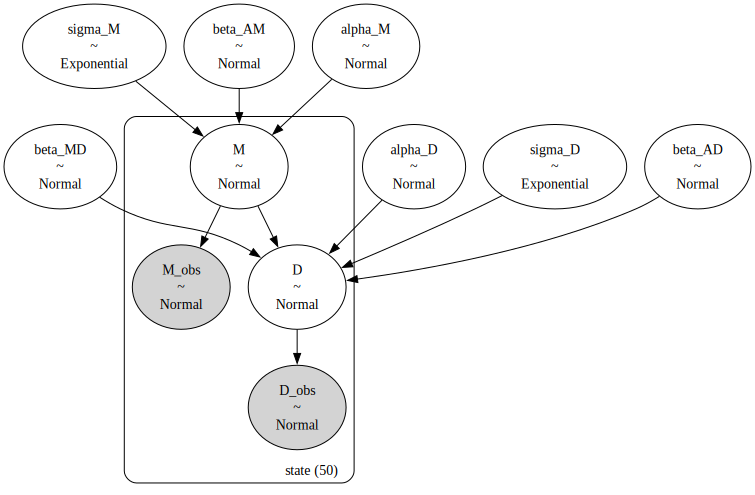

In [34]:
pm.model_to_graphviz(measured_divorce_marriage_model)

In [35]:
with measured_divorce_marriage_model:    
    measured_divorce_marriage_inference = pm.sample(tune=4000,
                                   draws=4000,
                                   chains=4,
                                   nuts_sampler='numpyro',
                                   target_accept=.9)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

#### The effect of modeling the Divorce and Marriage Rate measurment error

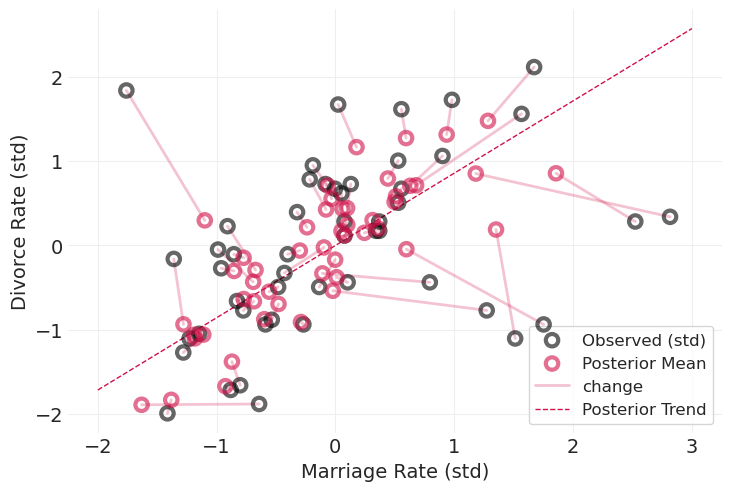

In [38]:
# Compute posterior means for true divorce and marriage rates
D_true = measured_divorce_marriage_inference.posterior.mean(dim=('chain', 'draw'))['D'].values
M_true = measured_divorce_marriage_inference.posterior.mean(dim=('chain', 'draw'))['M'].values

# Plot observed marriage vs. divorce rates
utils.plot_scatter(
    MARRIAGE,
    DIVORCE,
    color='k',
    label='Observed (std)',
    zorder=100
)

# Plot posterior means of marriage vs. divorce rates
utils.plot_scatter(
    M_true,
    D_true,
    color='C0',
    label='Posterior Mean',
    zorder=100
)

# Plot changes from observed to posterior means
plot_change_xy(MARRIAGE, DIVORCE, M_true, D_true)

# Compute the trend slope using least squares regression
trend_slope = np.linalg.lstsq(M_true[:, None], D_true, rcond=None)[0]

# Generate x values for the trendline
xs = np.linspace(-2, 3, 100)

# Compute corresponding y values for the trendline
ys = xs * trend_slope

# Plot the trendline
utils.plot_line(
    xs=xs,
    ys=ys,
    color='C0',
    linestyle='--',
    linewidth=1,
    label='Posterior Trend'
)

# Plot the highest density interval (HDI) at 89% for the posterior mean
#az.plot_hdi(M_true, measured_divorce_marriage_inference.posterior['D'], hdi_prob=0.89, color='C0', fill_kwargs={'alpha': 0.3})

# Label the axes
plt.xlabel("Marriage Rate (std)")
plt.ylabel("Divorce Rate (std)")

# Add a legend
plt.legend()

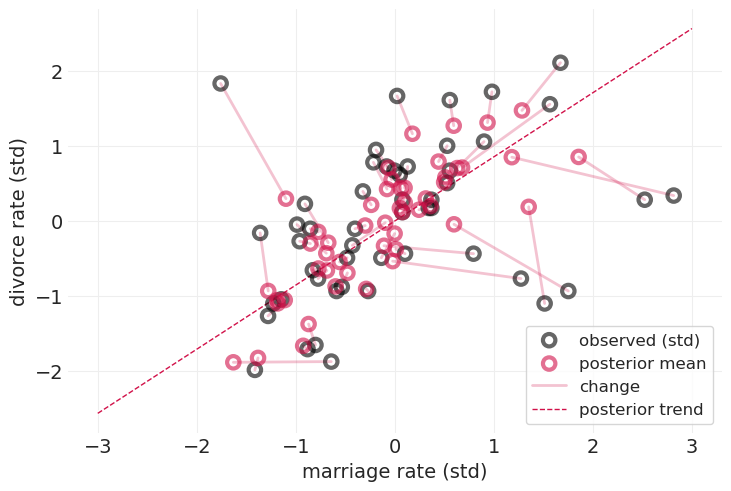

In [36]:
D_true = measured_divorce_marriage_inference.posterior.mean(dim=('chain', 'draw'))['D'].values
M_true = measured_divorce_marriage_inference.posterior.mean(dim=('chain', 'draw'))['M'].values

# Observations
utils.plot_scatter(
    MARRIAGE,
    DIVORCE,
    color='k',
    label='observed (std)',
    zorder=100
)

# Posterior Means
utils.plot_scatter(
    M_true,
    D_true,
    color='C0',
    label='posterior mean',
    zorder=100
)

# Change from modeling measurement error
plot_change_xy(MARRIAGE, DIVORCE, M_true, D_true)

# Add trendline
trend_slope = np.linalg.lstsq(M_true[:, None], D_true)[0]
xs = np.linspace(-2, 3, 10)
ys = xs * trend_slope
utils.plot_line(
    xs=xs,
    ys=ys,
    color='C0',
    linestyle='--',
    linewidth=1,
    label='posterior trend'
)

plt.xlabel("marriage rate (std)")
plt.ylabel("divorce rate (std)")
plt.legend()

- When modeling measurement error for both Marriage and Divorce, we get estimates that move in multiple dimensions
- Shrinkage (thin pink line) is toward the posterior trend (dashed red line)
  - the direction of movement is proporitonal to the uncertainty along the respective dimension
  - the degree of the movement is inversely proportional to the "quality" (in terms of std dev) of the data points
- Again, we get this all for free by writing down joint distribution and leaning on the axioms of probability

## Compare causal effects for models that do and do not model measurement error

### Fit model that considers no measurement error

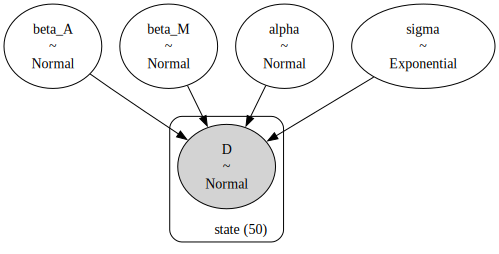

In [39]:
with pm.Model(coords=coords) as no_measurement_error_model:

    # Divorce Model
    ## Priors
    sigma = pm.Exponential("sigma", 1)
    alpha = pm.Normal("alpha", 0, 0.2)
    beta_A = pm.Normal("beta_A", 0, 0.5)
    beta_M = pm.Normal("beta_M", 0, 0.5)
    
    # observed
    mu = alpha + beta_A * AGE + beta_M * MARRIAGE
    pm.Normal("D", mu, sigma, observed=DIVORCE, dims='state')

pm.model_to_graphviz(no_measurement_error_model)

In [40]:
with no_measurement_error_model:    
    no_measurement_error_inference = pm.sample(tune=4000,
                                   draws=4000,
                                   chains=4,
                                   nuts_sampler='numpyro',
                                   target_accept=.9)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

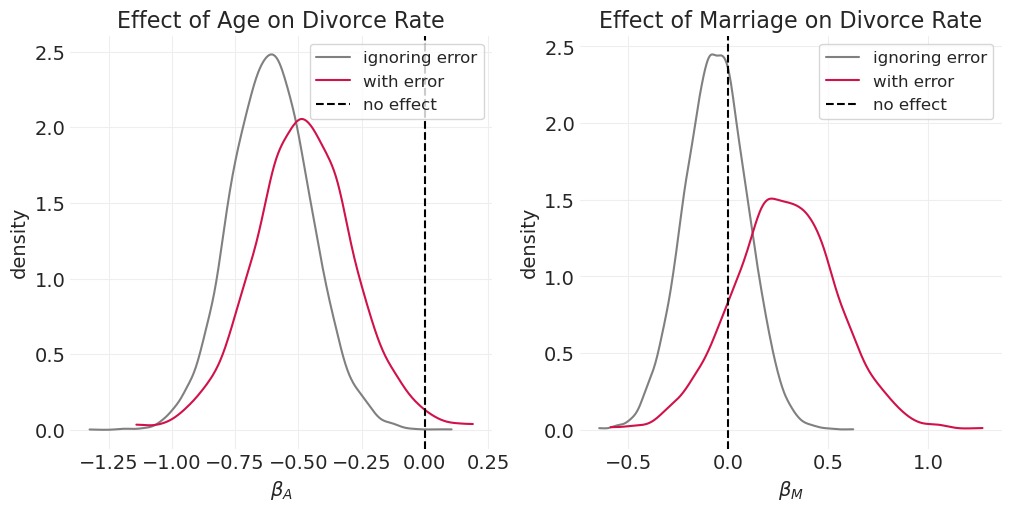

In [42]:
_, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
az.plot_dist(no_measurement_error_inference.posterior['beta_A'], color='gray', label='ignoring error')
az.plot_dist(measured_divorce_marriage_inference.posterior['beta_AD'], color='C0', label='with error')
plt.axvline(0, color='k', linestyle='--', label='no effect')
plt.xlabel("$\\beta_A$")
plt.ylabel("density")
plt.legend()
axs[0].set_title("Effect of Age on Divorce Rate")

plt.sca(axs[1])
az.plot_dist(no_measurement_error_inference.posterior['beta_M'], color='gray', label='ignoring error')
az.plot_dist(measured_divorce_marriage_inference.posterior['beta_MD'], color='C0', label='with error')
plt.axvline(0, color='k', linestyle='--', label='no effect')
plt.xlabel("$\\beta_M$")
plt.ylabel("density")
plt.legend()
axs[1].set_title("Effect of Marriage on Divorce Rate");

#### Again, no clear rule for how measurment error will effect causal estimates

- Estimated effect of age is attenuated when accounting for measurement error (left)
- Estimated effect of marriage on divorce rate increases when modeling measurement error (right)
- Effects of age and marriage found in previous examples could be due in part to measurement error and/or population confounds

## Unpredictable Errors

- Modeling measurment error of Marriage increases the estiamted effect of Marriage on Divorce
  - This is not intuitive
    - your intuitions are the devil 😈
  - Often results for nonlinear interactions are not intuitive -- rely on probability theory
  - Likely due to down-weighting the effect of unreliable, high-uncertainty datapoints, improving the estimate
- Errors can "hurt" or "help", depending on goals
  - only honest option is to attempt to model them
  - do the best you can, analyze your data like you wish your collegues would analyze their own.


# Misclassification

## [Paternity in Himba pastoralist culture](https://www.science.org/doi/10.1126/sciadv.aay6195)

- Unusual kinships systems (in a Western sense, anyway)
- "Open" marriages
- **Estimand**: proportion of children fathered by men in extra-marital relationships $p$
- **Misclassification**: categorical version of measurement error
  - Paternity Test has some false positive rate $f$ (FPR, say 5%)
  - If the rate of extra-marital paternity is small, it may be on the same order as the FPR
    - thus often can't ignore the misclassification error
  - How do we include misclassification rate?


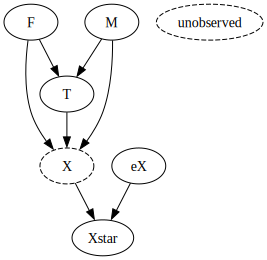

In [20]:
utils.draw_causal_graph(
    edge_list=[
        ("F", "X"),
        ("F", "T"),
        ("T", "X"),
        ("M", "T"),
        ("M", "X"),
        ("X", "Xstar"),
        ("eX", "Xstar")
    ],
    node_props={
        "X": {"style": "dashed"},
        "unobserved": {"style": "dashed"}
        
    }
)

- social father $F$
- mother $M$
- social ties (dyads) $T$
- _actual_ extra-marital paternity $X$, unobserved
- _measured_ extra-marital paternity $X^*$
- misclassification errors $e_X$

### Generative Model
$$
\begin{align*}
X_i &\sim \text{Bernoulli}(p_i) \\
\text{logit}(p_i) &= \alpha + \mu_{M[i]} + \delta_{T[i]}
\end{align*}
$$

### Measurement Model

$$
\begin{align*}
P(X^*=1 | p_i) = p_i + (1 - p_i)f \\
P(X^*=0 | p_i) = (1 - p_i)(1 - f)
\end{align*}
$$

With
- error rate $f$
- probability of extra-marital paternity $p$

#### Deriving the Misclassification Error Model graphically:

Not being clever, right out all possible measurement outcomes

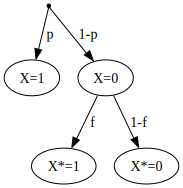

In [21]:
utils.draw_causal_graph(
    edge_list=[
        ("", "X=1"),
        ("", "X=0"),
        ("X=0", "X*=1"),
        ("X=0", "X*=0"),
        
    ],
    node_props={
        "": {"shape": "point"}
    },
    edge_props={
        ("", "X=1"): {"label": " p"},
        ("", "X=0"): {"label": " 1-p", },
        ("X=0", "X*=1"): {"label": " f",},
        ("X=0", "X*=0"): {"label": " 1-f"}
    }
)

#### $p(X^*=1) = p + (1-p)f$ 

The probability of observing $X=1$ given $p$ is the red path below

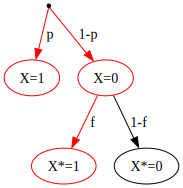

In [22]:
utils.draw_causal_graph(
    edge_list=[
        ("", "X=1"),
        ("", "X=0"),
        ("X=0", "X*=1"),
        ("X=0", "X*=0"),
        
    ],
    node_props={
        "": {"shape": "point"},
        "X=1": {"color": "red"},
        "X=0": {"color": "red"},
        "X*=1": {"color": "red"},
    },
    edge_props={
        ("", "X=1"): {"label": " p", "color": "red"},
        ("", "X=0"): {"label": " 1-p", "color": "red"},
        ("X=0", "X*=1"): {"label": " f", "color": "red"},
        ("X=0", "X*=0"): {"label": " 1-f"}
    }
)

#### $p(X^*=0) = (1-p)(1-f)$ 

The probability of observing $X=0$ given $p$ is the red path below

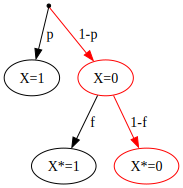

In [23]:
utils.draw_causal_graph(
    edge_list=[
        ("", "X=1"),
        ("", "X=0"),
        ("X=0", "X*=1"),
        ("X=0", "X*=0"),
        
    ],
    node_props={
        "": {"shape": "point"},
        "X=0": {"color": "red"},
        "X*=0": {"color": "red"},
    },
    edge_props={
        ("", "X=1"): {"label": " p"},
        ("", "X=0"): {"label": " 1-p", "color": "red"},
        ("X=0", "X*=0"): {"label": " 1-f",  "color": "red"},
        ("X=0", "X*=1"): {"label": " f"}
    }
)

### Generating a Proxy Dataset

AFAICT, the dataset in the Scelza et al. paper isn't publicly available, so let's simulate one from the process defined by the generative model.

In [3]:
# Improved code
from itertools import product as iproduct

# Set random seed for reproducibility
np.random.seed(123)

# Parameters
N_MOTHERS = 30
N_FATHERS = 15
FALSE_POSITIVE_RATE = 0.05
ALPHA = 0 
BETA_MOTHER_TRAIT = 1
BETA_RELATIONSHIP = 3

# Generate IDs for mothers and fathers
MOTHER_IDS = np.arange(N_MOTHERS)
FATHER_IDS = np.arange(N_FATHERS)

# Generate traits for mothers
MOTHER_TRAITS = stats.norm.rvs(size=N_MOTHERS)

# Generate all possible dyads (mother-father pairs)
DYADS = np.array(list(iproduct(MOTHER_IDS, FATHER_IDS)))
N_DYADS = len(DYADS)

# Generate relationship scores for each dyad
RELATIONSHIPS = stats.norm.rvs(size=N_DYADS)

# Create a DataFrame to hold the paternity data
PATERNITY = pd.DataFrame({
    "mother_id": DYADS[:, 0],
    "social_father_id": DYADS[:, 1],
    "dyad_id": np.arange(N_DYADS),
    "relationship": RELATIONSHIPS
})

# Add mother traits to the DataFrame
PATERNITY["mother_trait"] = PATERNITY["mother_id"].apply(lambda x: MOTHER_TRAITS[x])

# Calculate the probability of being the father (logistic regression model)
p_father = utils.invlogit(
    ALPHA + BETA_MOTHER_TRAIT * PATERNITY["mother_trait"] + BETA_RELATIONSHIP * PATERNITY["relationship"]
)
PATERNITY["p_father"] = p_father

# Determine actual paternity (unobserved true state)
PATERNITY["is_father"] = stats.bernoulli.rvs(p_father)

# Measurement model: calculate observed paternity probability
def p_father_star(row):
    """
    Calculate the observed paternity probability accounting for false positives.

    Parameters:
    row : pd.Series
        A row of the DataFrame representing a dyad.

    Returns:
    float
        Adjusted probability of being the father.
    """
    if row.is_father == 1:
        return row.p_father + (1 - row.p_father) * FALSE_POSITIVE_RATE
    return 1 - (1 - row.p_father) * (1 - FALSE_POSITIVE_RATE)

# Apply the measurement model to calculate observed probabilities
PATERNITY["p_father_star"] = PATERNITY.apply(p_father_star, axis=1)

# Determine observed paternity (with measurement error)
PATERNITY["is_father_star"] = stats.bernoulli.rvs(p=PATERNITY["p_father_star"].values)

# Print results
print('Actual average paternity rate: ', PATERNITY["is_father"].mean().round(2))
print('Measured average paternity rate: ', PATERNITY["is_father_star"].mean().round(2))


Actual average paternity rate:  0.48
Measured average paternity rate:  0.53


We print out the actual, and observed paternity rates above. In principle, we should be able to recover these with our model

In [4]:
PATERNITY

,mother_id,social_father_id,dyad_id,relationship,mother_trait,p_father,is_father,p_father_star,is_father_star
0,0,0,0,-0.255619,-1.085631,0.135581,0,0.178802,0
1,0,1,1,-2.798589,-1.085631,0.000076,0,0.050072,0
2,0,2,2,-1.771533,-1.085631,0.001658,0,0.051575,0
3,0,3,3,-0.699877,-1.085631,0.039724,0,0.087738,0
4,0,4,4,0.927462,-1.085631,0.845111,1,0.852855,0
...,...,...,...,...,...,...,...,...,...
445,29,10,445,-0.581850,-0.861755,0.068670,0,0.115236,0
446,29,11,446,-0.659560,-0.861755,0.055178,0,0.102419,1
447,29,12,447,0.750945,-0.861755,0.800764,1,0.810726,1
448,29,13,448,-2.438461,-0.861755,0.000281,0,0.050267,0


### Fit the model with misclassification error

#### Notes
- we average over the unknown $X_i$, so we have no likelihood, and thus do not need the $X_i \sim \text{Bernoulli}(p_i)$ term in the model
- But we still include an observation model, where we use two simultanous distributions, based on our observation:
  - if $X^*=1$ we use $p(X^*=1) = p + (1-p)f$
  - if $X^*=0$ we use $p(X^*=0) = (1-p)(1-f)$
  - To use these custom distributions, we leverage the `pm.Potential` function, which takes in the log probability of each observational distribution
    - this is analogous to the `custom` function used in lecture
  - We use the vanilla implementation below, one that doesn't use the `logsumexp`, etc. functions, as it compiles just fine

In [31]:
# Data prep
MOM_TRAITS = PATERNITY.mother_trait.values
DYAD_ID, DYAD = pd.factorize(PATERNITY.dyad_id)
MOM_ID, MOTHER = pd.factorize(PATERNITY.mother_id)

coords = {'ties': DYAD, 'mother': MOTHER}

<Axes: >

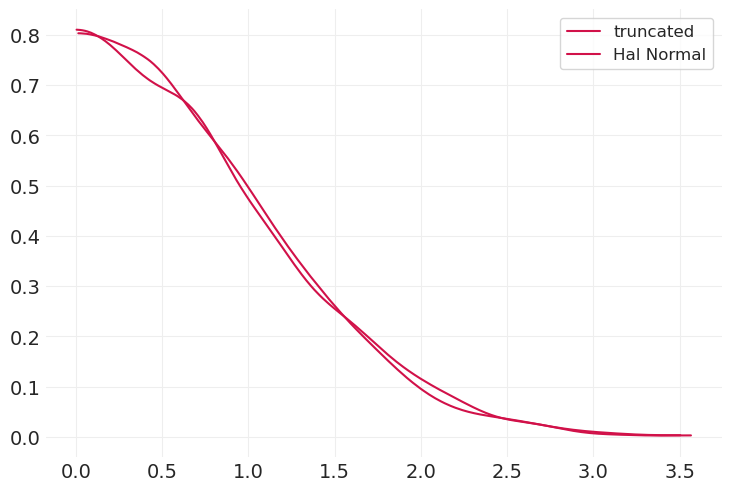

In [12]:
import utils

fig, ax = plt.subplots()

# Plot multiple distributions
utils.plot_pymc_distribution(pm.TruncatedNormal, mu=0, sigma=1, lower=0.01, ax=ax, label='truncated')
utils.plot_pymc_distribution(pm.HalfNormal, sigma=1, ax=ax, label='Hal Normal')

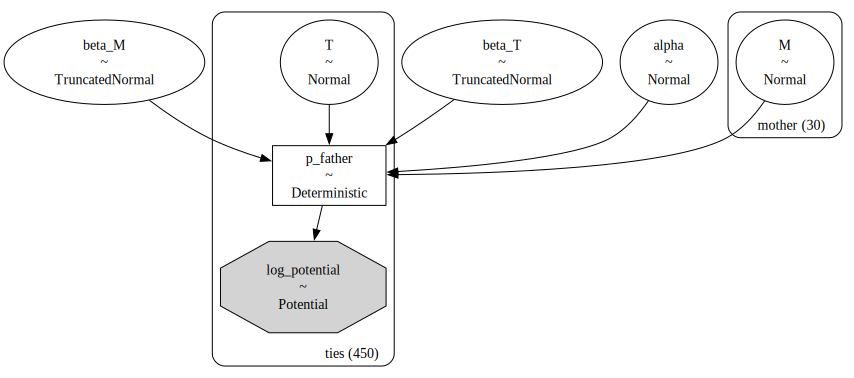

In [80]:
# Model with measurement error combining potential functions into one

with pm.Model(coords=coords) as paternity_measurement_model_bis:
    
    # Priors
    beta_M = pm.TruncatedNormal("beta_M", mu=0, sigma=1, lower=0.01)  # Prior for mother traits effect
    beta_T = pm.TruncatedNormal("beta_T", mu=0, sigma=1, lower=0.01)  # Prior for relationship strength effect
    alpha = pm.Normal("alpha", mu=0, sigma=1.5)  # Intercept

    T = pm.Normal("T", mu=0, sigma=1, dims='ties')    # Relationship strength for each dyad
    M = pm.Normal("M", mu=0, sigma=1, dims='mother')  # Mother traits for each mother

    # Deterministic transformation to calculate the probability of being the father
    p_father = pm.Deterministic('p_father', pm.math.invlogit(alpha + M[MOM_ID] * beta_M + T[DYAD_ID] * beta_T), dims='ties')

    # Custom potential to account for measurement error and misclassification

    # True positive case: X* = 1
    # Probability of observing a positive match (father) given the true probability and false positive rate
    log_p_x1 = pm.math.log(p_father + (1 - p_father) * FALSE_POSITIVE_RATE)

    # True negative case: X* = 0
    # Probability of observing a negative match (not father) given the true probability and false positive rate
    log_p_x0 = pm.math.log((1 - p_father) * (1 - FALSE_POSITIVE_RATE))

    # Combined log potential function for the observed data
    pm.Potential("log_potential", log_p_x1 + log_p_x0, dims="ties")

pm.model_to_graphviz(paternity_measurement_model_bis)

In [15]:
with paternity_measurement_model_bis:
    paternity_measurement_inference_bis = pm.sample(tune=4000,
                                   draws=4000,
                                   chains=4,
                                   nuts_sampler='numpyro',
                                   target_accept=.9)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

In [16]:
az.summary(paternity_measurement_inference_c, var_names=["beta_T", "beta_M", "alpha", "M"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_T,0.063,0.041,0.010,0.138,0.000,0.000,14329.0,7779.0,1.0
beta_M,0.067,0.045,0.010,0.147,0.000,0.000,13001.0,7699.0,1.0
alpha,-0.106,0.072,-0.238,0.035,0.001,0.000,20089.0,11945.0,1.0
M[0],0.004,0.990,-1.839,1.884,0.007,0.008,19591.0,10950.0,1.0
M[1],0.009,0.994,-1.838,1.898,0.007,0.009,21699.0,11624.0,1.0
M[2],0.008,0.981,-1.889,1.785,0.007,0.008,20633.0,11881.0,1.0
M[3],0.001,0.988,-1.750,1.997,0.007,0.008,19466.0,11691.0,1.0
M[4],-0.007,0.984,-1.824,1.879,0.007,0.008,20026.0,11799.0,1.0
M[5],0.010,0.976,-1.791,1.868,0.007,0.008,19786.0,11389.0,1.0
M[6],0.007,0.978,-1.859,1.819,0.007,0.008,20542.0,11330.0,1.0


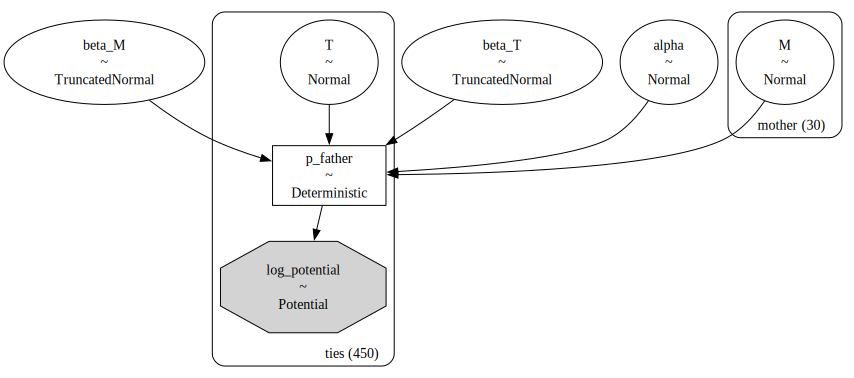

In [86]:
from utils import pymc_sample
idata_log = pymc_sample(paternity_measurement_model_log, log_likelihood=False)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

There were 16000 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [87]:
az.summary(paternity_measurement_inference_c, var_names=["beta_T", "beta_M", "alpha", "M"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_T,0.063,0.041,0.010,0.138,0.000,0.000,14329.0,7779.0,1.0
beta_M,0.067,0.045,0.010,0.147,0.000,0.000,13001.0,7699.0,1.0
alpha,-0.106,0.072,-0.238,0.035,0.001,0.000,20089.0,11945.0,1.0
M[0],0.004,0.990,-1.839,1.884,0.007,0.008,19591.0,10950.0,1.0
M[1],0.009,0.994,-1.838,1.898,0.007,0.009,21699.0,11624.0,1.0
M[2],0.008,0.981,-1.889,1.785,0.007,0.008,20633.0,11881.0,1.0
M[3],0.001,0.988,-1.750,1.997,0.007,0.008,19466.0,11691.0,1.0
M[4],-0.007,0.984,-1.824,1.879,0.007,0.008,20026.0,11799.0,1.0
M[5],0.010,0.976,-1.791,1.868,0.007,0.008,19786.0,11389.0,1.0
M[6],0.007,0.978,-1.859,1.819,0.007,0.008,20542.0,11330.0,1.0


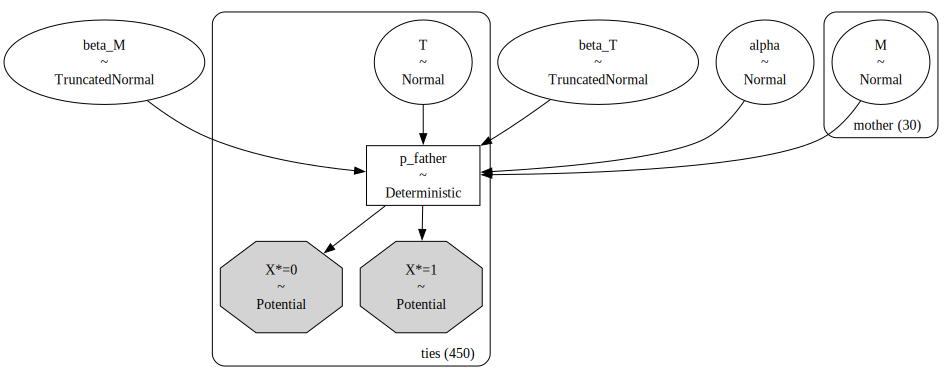

In [8]:
# Model with measurement error

with pm.Model(coords=coords) as paternity_measurement_model_c:
    
    # Priors
    beta_M = pm.TruncatedNormal("beta_M", 0, 1, lower=0.01)
    beta_T = pm.TruncatedNormal("beta_T", 0, 1, lower=0.01)
    alpha = pm.Normal("alpha", 0, 1.5)
    
    T = pm.Normal("T", 0, 1, dims='ties')    # Relationship strength
    M = pm.Normal("M", 0, 1, dims='mother')  # Mother traits

    # likelihood
    p_father = pm.Deterministic('p_father', pm.math.invlogit(alpha + M[MOM_ID] * beta_M + T[DYAD_ID] * beta_T), dims='ties')

    custom_log_p_x1 = pm.math.log(p_father + (1 - p_father) * FALSE_POSITIVE_RATE)
    pm.Potential("X*=1", custom_log_p_x1, dims='ties')

    custom_log_p_x0 = pm.math.log((1 - p_father) * (1 - FALSE_POSITIVE_RATE))
    pm.Potential("X*=0", custom_log_p_x0, dims='ties')

pm.model_to_graphviz(paternity_measurement_model_c)

In [13]:
with paternity_measurement_model_c:
    paternity_measurement_inference_c = pm.sample(tune=4000,
                                   draws=4000,
                                   chains=4,
                                   nuts_sampler='numpyro',
                                   target_accept=.9)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

In [56]:
az.summary(paternity_measurement_inference_c, var_names=["beta_T", "beta_M", "alpha", "M"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_T,0.063,0.041,0.010,0.137,0.000,0.000,14088.0,7023.0,1.0
beta_M,0.067,0.045,0.010,0.148,0.000,0.000,13354.0,7021.0,1.0
alpha,-0.107,0.073,-0.242,0.032,0.000,0.000,21846.0,11817.0,1.0
M[0],0.007,0.985,-1.827,1.868,0.006,0.008,23757.0,11866.0,1.0
M[1],0.003,0.985,-1.894,1.777,0.006,0.009,23866.0,11706.0,1.0
M[2],-0.003,0.981,-1.898,1.777,0.006,0.008,22776.0,11386.0,1.0
M[3],0.003,0.989,-1.828,1.912,0.006,0.009,23172.0,11807.0,1.0
M[4],-0.001,0.969,-1.701,1.925,0.006,0.008,22739.0,11787.0,1.0
M[5],-0.001,0.995,-1.875,1.867,0.006,0.008,24438.0,12482.0,1.0
M[6],-0.011,0.971,-1.823,1.816,0.006,0.008,25118.0,12177.0,1.0


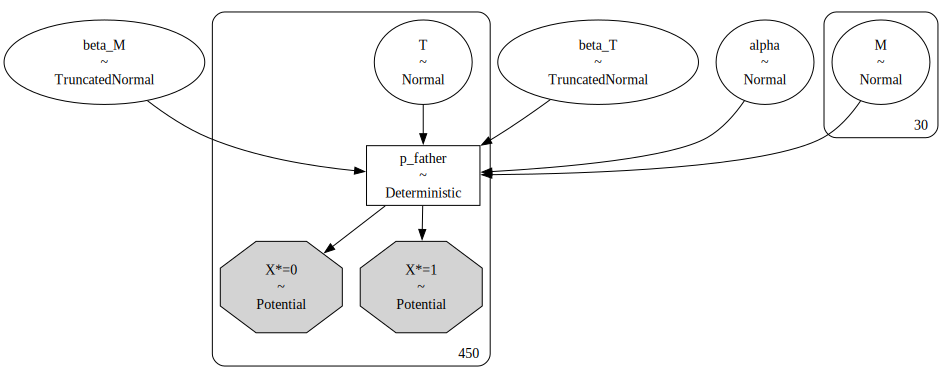

In [17]:
# original model with no coords
MOM_ID = PATERNITY.mother_id
MOM_TRAITS = PATERNITY.mother_trait.values

with pm.Model() as paternity_measurement_model:
    
    # Priors
    beta_M = pm.TruncatedNormal("beta_M", 0, 1, lower=0.01)
    beta_T = pm.TruncatedNormal("beta_T", 0, 1, lower=0.01)
    
    alpha = pm.Normal("alpha", 0, 1.5)
    T = pm.Normal("T", 0, 1, shape=N_DYADS)    # Relationship strength
    M = pm.Normal("M", 0, 1, shape=N_MOTHERS)  # Mother traits

    p_father = pm.Deterministic('p_father', pm.math.invlogit(alpha + M[MOM_ID] * beta_M + T[DYAD_ID] * beta_T))

    custom_log_p_x1 = pm.math.log(p_father + (1 - p_father) * FALSE_POSITIVE_RATE)
    pm.Potential("X*=1", custom_log_p_x1)

    custom_log_p_x0 = pm.math.log((1 - p_father) * (1 - FALSE_POSITIVE_RATE))
    pm.Potential("X*=0", custom_log_p_x0)

pm.model_to_graphviz(paternity_measurement_model)

In [18]:
with paternity_measurement_model:
    paternity_measurement_inference = pm.sample(tune=4000,
                                   draws=4000,
                                   chains=4,
                                   nuts_sampler='numpyro',
                                   target_accept=.9)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

In [19]:
az.summary(paternity_measurement_inference, var_names=["beta_T", "beta_M", "alpha", "M"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_T,0.063,0.041,0.010,0.136,0.000,0.000,12975.0,6890.0,1.0
beta_M,0.066,0.044,0.010,0.146,0.000,0.000,14225.0,8281.0,1.0
alpha,-0.106,0.073,-0.242,0.030,0.000,0.000,25438.0,12160.0,1.0
M[0],-0.003,0.987,-1.887,1.852,0.006,0.009,27490.0,11187.0,1.0
M[1],-0.001,0.993,-1.850,1.885,0.006,0.009,26262.0,11611.0,1.0
M[2],-0.002,0.982,-1.832,1.846,0.006,0.009,28139.0,11408.0,1.0
M[3],-0.011,0.987,-1.832,1.852,0.006,0.009,27467.0,11312.0,1.0
M[4],0.004,0.982,-1.729,1.972,0.006,0.009,26095.0,11352.0,1.0
M[5],-0.002,0.981,-1.855,1.879,0.006,0.008,26421.0,11991.0,1.0
M[6],-0.005,0.971,-1.852,1.767,0.006,0.009,28202.0,11408.0,1.0


### Fit analogous model without accouting for misclassification

In [21]:
# Assume observation as true
IS_FATHER_STAR = PATERNITY['is_father_star'].values

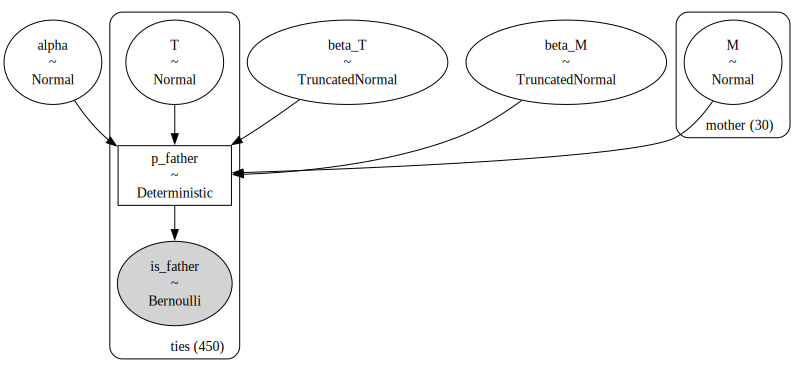

In [22]:

with pm.Model(coords=coords) as paternity_model:

    alpha = pm.Normal("alpha", 0, 1.5)
    beta_M = pm.TruncatedNormal("beta_M", 0, 1, lower=0.01)
    beta_T = pm.TruncatedNormal("beta_T", 0, 1, lower=0.01)
    
    T = pm.Normal("T", 0, 1, dims='ties')    # Relationship strength
    M = pm.Normal("M", 0, 1, dims='mother')  # Mother traits

    p_father = pm.Deterministic('p_father', pm.math.invlogit(alpha + M[MOM_ID] * beta_M + T[DYAD_ID] * beta_T), dims='ties')
    
    pm.Bernoulli('is_father', p_father, observed=IS_FATHER_STAR, dims='ties')
   
pm.model_to_graphviz(paternity_model)

In [23]:
with paternity_model:
    paternity_inference = pm.sample(tune=4000,
                                   draws=4000,
                                   chains=4,
                                   nuts_sampler='numpyro',
                                   target_accept=.9)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Actual average paternity rate:  0.48
Measured average paternity rate:  0.53


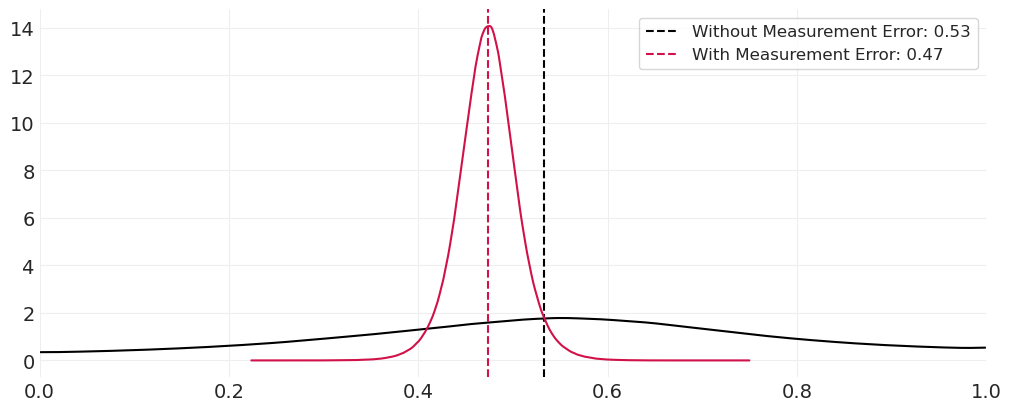

In [24]:
plt.subplots(figsize=(10, 4))
az.plot_dist(paternity_inference.posterior['p_father'], color='k')
p_father_mean = paternity_inference.posterior['p_father'].mean()
plt.axvline(p_father_mean, color='k', linestyle='--', label=f"Without Measurement Error: {p_father_mean:1.2f}")


az.plot_dist(paternity_measurement_inference_bis.posterior['p_father'])

p_father_mean_bis = paternity_measurement_inference_bis.posterior['p_father'].mean()

plt.axvline(p_father_mean_bis, linestyle='--', label=f"With Measurement Error: {p_father_mean_bis:1.2f}")
plt.xlim([0, 1])
plt.legend()

plt.legend()
print('Actual average paternity rate: ', PATERNITY['is_father'].mean().round(2))
print('Measured average paternity rate: ', PATERNITY['is_father_star'].mean().round(2))


- Including measurment error, we're able to accurately recover the _actual_ average paternity rate.
- Without including the measurement error in the model, we recover the paternity rate observed in the presence of misclassification error.
- At least for with this simulated dataset, including measurment error gives us a much tigher posterior on the estimated paternity rate, when compared to not modeling the misclassification error in the model.

## Measurement & Misclassification Horizons

There are a number of problems and solutions related to modeling measurment error and misclassification

- Item response theory (IRT)
  - e.g. NJ wine judging example earlier
- Factor Analysis
- Hurdle models
  - measurments need to cross a threshold before they are identifiable
- Occupancy models
  - considering the existence of phenomena without detection
  - big in applied ecology: just because a species isn't detected doesn't mean it isn't there

# BONUS: Floating Point Monsters

- Working on log scale avoids (er, minimizes) issues associated with floating point arithmetic overflow (rounding to one) or underflow (rounding to zero)
- "ancient weapons": special functions for working log scale:
  - `pm.logsumexp`: efficiently computes the log of the sum of exponentials of input elements.
  - `pm.math.log1mexp`: calculates $\log(1 - \exp(-x))$
  - `pm.log(1 - p)`

### Logs make sense

$$
\begin{align*}
P(X^*=0) &= (1-p)(1-f) \\
\log P(X^*=0) & = \log (1-p) + \log (1-f)  &\text{put on log scale (used by HMC)}
\end{align*}
$$

### Devil's in the detail

Some terms can become numerically unstable

- e.g. if $p \approx 0, \log(1-p) \approx \log(1) = 0$
- e.g. if $p \approx 1, \log(1-p) \approx \log(0) = -\infty$

In [29]:
for p in [1e-2, 1e-10, 1e-90]:
    print('p:', p, ', log(1-p):', np.log(1-p))

p: 0.01 , log(1-p): -0.01005033585350145
p: 1e-10 , log(1-p): -1.000000082790371e-10
p: 1e-90 , log(1-p): 0.0


In [30]:
def log1m(x):
    return np.log1p(-x)

for p in [1e-2, 1e-10, 1e-90]:
    print('p:', p, ', log1p(1-p):', log1m(p))

p: 0.01 , log1p(1-p): -0.010050335853501442
p: 1e-10 , log1p(1-p): -1.00000000005e-10
p: 1e-90 , log1p(1-p): -1e-90


### `log1p` and Taylor series approximation for small $p$

- when $p>e{-4}$, just calculate $\log(1 + p)$
- when $p<e{-4}$, use Taylor expansion: $\log(1 + p) = p - \frac{p^2}{2} + \frac{p^3}{3} - ...$

In [31]:
def my_log1p(x):
    if x > 1e-4:
        return np.log(1 + x)
    else:
        # second order Taylor expansion
        return x - x ** 2 / 2

# Compare results to numpy log1p
for p in [1e-3, 1e-10, 1e-90]:
    print('p:', p, ', numpy.log1p:', np.log1p(p), ', my_log1p', my_log1p(p))

p: 0.001 , numpy.log1p: 0.0009995003330835331 , my_log1p 0.0009995003330834232
p: 1e-10 , numpy.log1p: 9.999999999500001e-11 , my_log1p 9.999999999500001e-11
p: 1e-90 , numpy.log1p: 1e-90 , my_log1p 1e-90


In [47]:
def pm_log1p(x):
    if x > 1e-4:
        return pm.math.log(1 + x)
    else:
        # second order Taylor expansion
        return x - pm.math.sqr(x) / 2

In [54]:

pm.math.log(1 + 1e-90).eval()

array(0., dtype=float32)

In [44]:
for p in [1e-3, 1e-10, 1e-90]:
    print('p:', p, ', numpy.log1p:', np.log1p(p), ', pm_log1p', pm.math.log(1 + p).eval())

p: 0.001 , numpy.log1p: 0.0009995003330835331 , pm_log1p 0.0009995003330834232
p: 1e-10 , numpy.log1p: 9.999999999500001e-11 , pm_log1p 1.000000082690371e-10
p: 1e-90 , numpy.log1p: 1e-90 , pm_log1p 0.0


## `logsumexp`

- Use when you need to take the sum of log of multiple terms.
- Want the log because it will be numerically stable
- But logs don't apply to sum, only products, e.g.

$$
\begin{align*}
P(X^*=1) &=  p + (1-p)f \\
\log P(X^*=1) &=  \log [p + (1-p)f] \\
\log P(X^*=1) &= \text{pm.math.logsumexp}([\text{pm.math.log}(p), \text{pm.math.log}(1-p) + \text{pm.math.log}(f))]) \\
\log P(X^*=1) &= \text{pm.math.logsumexp}([\text{pm.math.log}(p), \text{log1m}(p)) + \text{pm.math.log}(f))])
\end{align*}
$$


## Previous Paternity measurement model with log-scaling tricks

In [45]:
p_father = 0.5
pm.math.logsumexp((pm.math.log(p_father), pm.math.log(1 - p_father) + pm.math.log(FALSE_POSITIVE_RATE))).eval()
# pm.math.log(FALSE_POSITIVE_RATE).astype('float32').eval()

array(-0.64435702)

In [46]:
pm.math.logsumexp((pm.math.log(p_father), np.log1p(-p_father) + pm.math.log(FALSE_POSITIVE_RATE))).eval()

array(-0.64435702)

In [33]:
# Helper functions
def log_sum_exp(a, b):
    """
    Simple, numerically-stable logsumexp implementation for two inputs.

    Ironically, using `pm.math.logsumexp` for this implementation was
    providing numerically results.
    
    It looks like the PyMC5 implementation uses vanilla `exp`, `sum`,
    and `log` operators, which likely isn't numerically stable:

    https://www.pymc.io/projects/docs/en/stable/_modules/pytensor/tensor/math.html#logsumexp
    """
    c = pm.math.maximum(a, b)
    return c + pm.math.log(pm.math.exp(a - c) + pm.math.exp(b - c))


def log1p(x):
    return pm.math.log(1 + x)

def log1m(x):
    return log1p(-x)


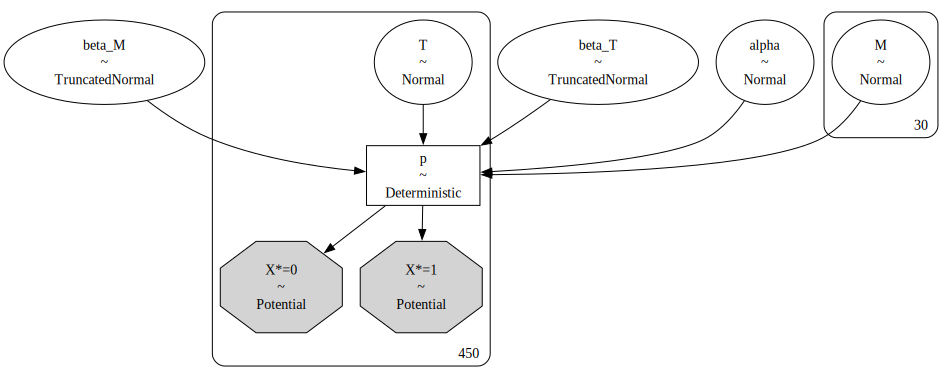

In [41]:
# original code
with pm.Model() as paternity_measurement_lse_model:
    
    beta_M = pm.TruncatedNormal("beta_M", 0, 1, lower=0.01)
    beta_T = pm.TruncatedNormal("beta_T", 0, 1, lower=0.01)
    
    alpha = pm.Normal("alpha", 0, 1.5)
    T = pm.Normal("T", 0, 1, shape=N_DYADS)    # Relationship strength
    M = pm.Normal("M", 0, 1, shape=N_MOTHERS)  # Mother traits

    p = pm.Deterministic('p', pm.math.invlogit(alpha + M[MOM_ID] * beta_M + T[DYAD_ID] * beta_T))
    f = FALSE_POSITIVE_RATE

    # # For reference: the original custom logp with vanilla parameterization
    # custom_log_p_x1 = pm.math.log(p + (1 - p) * f)
    # custom_log_p_x0 = pm.math.log((1 - p) * (1 - f))

    # Custom logp using log-space reparameterization
    custom_log_p_x1 = log_sum_exp(pm.math.log(p), log1m(p) + pm.math.log(f))  # this line is problematic
    custom_log_p_x0 = log1m(p) + log1m(f)
    
    pm.Potential("X*=1", custom_log_p_x1)
    pm.Potential("X*=0", custom_log_p_x0)

pm.model_to_graphviz(paternity_measurement_lse_model)

In [93]:
paternity_measurement_lse_inference = pymc_sample(paternity_measurement_lse_model, log_likelihood=False)
    

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

In [85]:
import importlib
importlib.reload(utils)
from utils import pymc_sample

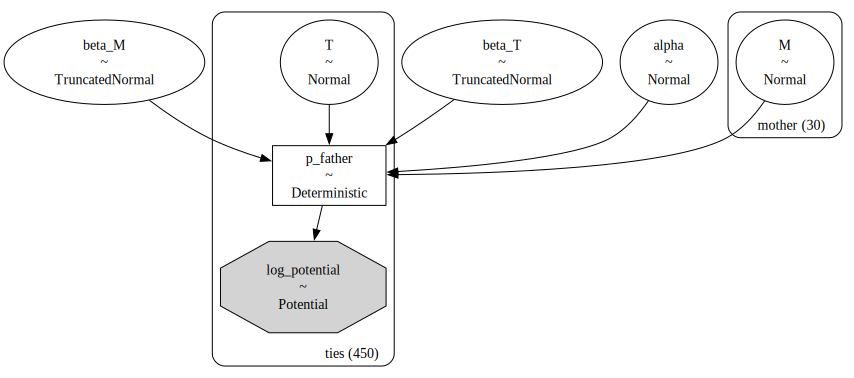

In [94]:
# Model with measurement error and logP other parametrization
#  father calculation NOT Sampling properly

with pm.Model(coords=coords) as paternity_measurement_model_log:
    
    log_f = pm.math.log(FALSE_POSITIVE_RATE)

    # Priors
    beta_M = pm.TruncatedNormal("beta_M", mu=0, sigma=1, lower=0.01)  # Prior for mother traits effect
    beta_T = pm.TruncatedNormal("beta_T", mu=0, sigma=1, lower=0.01)  # Prior for relationship strength effect
    alpha = pm.Normal("alpha", mu=0, sigma=1.5)  # Intercept

    T = pm.Normal("T", mu=0, sigma=1, dims='ties')    # Relationship strength for each dyad
    M = pm.Normal("M", mu=0, sigma=1, dims='mother')  # Mother traits for each mother

    # Deterministic transformation to calculate the probability of being the father
    # Calculate log to make calculation more numerically stable
    log_p_father = pm.Deterministic('p_father', 
                                    pm.math.log(pm.invlogit(alpha + M[MOM_ID] * beta_M + T[DYAD_ID] * beta_T)), 
                                    dims='ties')

    # Custom potential to account for measurement error and misclassification
    # True positive case: X* = 1
    # Probability of observing a positive match (father) given the true probability and false positive rate
    log_p_x1 = pm.logsumexp([log_p_father, pm.math.log1mexp(log_p_father) + log_f], keepdims=True)

    # True negative case: X* = 0
    # Probability of observing a negative match (not father) given the true probability and false positive rate
    log_p_x0 = pm.math.log1mexp(log_p_father) + pm.math.log1mexp(log_f)

    # Combined log potential function for the observed data
    pm.Potential("log_potential", log_p_x1 + log_p_x0, dims="ties")

pm.model_to_graphviz(paternity_measurement_model_log)

In [95]:
paternity_measurement_inference_log = pymc_sample(paternity_measurement_model_log, log_likelihood=False)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

There were 16000 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


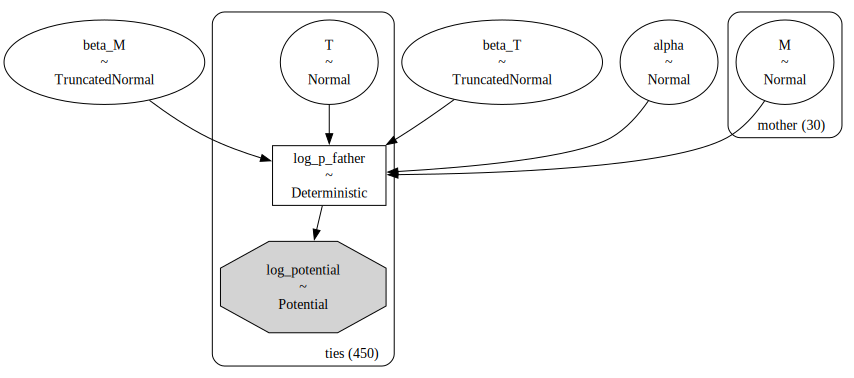

In [98]:
with pm.Model(coords=coords) as paternity_measurement_model_log:
    
    log_f = pm.math.log(FALSE_POSITIVE_RATE)

    # Priors
    beta_M = pm.TruncatedNormal("beta_M", mu=0, sigma=1, lower=0.01)  # Prior for mother traits effect
    beta_T = pm.TruncatedNormal("beta_T", mu=0, sigma=1, lower=0.01)  # Prior for relationship strength effect
    alpha = pm.Normal("alpha", mu=0, sigma=1.5)  # Intercept

    T = pm.Normal("T", mu=0, sigma=1, dims='ties')    # Relationship strength for each dyad
    M = pm.Normal("M", mu=0, sigma=1, dims='mother')  # Mother traits for each mother

    # Deterministic transformation to calculate the probability of being the father
    # Calculate log to make calculation more numerically stable
    logit_p_father = alpha + M[MOM_ID] * beta_M + T[DYAD_ID] * beta_T
    log_p_father = pm.Deterministic('log_p_father', pm.math.log(pm.invlogit(logit_p_father)), dims='ties')

    # Custom potential to account for measurement error and misclassification
    # True positive case: X* = 1
    # Probability of observing a positive match (father) given the true probability and false positive rate
    log_p_x1 = pm.logsumexp([log_p_father, pm.math.log1mexp(log_p_father) + log_f], axis=0)

    # True negative case: X* = 0
    # Probability of observing a negative match (not father) given the true probability and false positive rate
    log_p_x0 = pm.math.log1mexp(log_p_father) + pm.math.log1mexp(log_f)

    # Combined log potential function for the observed data
    pm.Potential("log_potential", log_p_x1 + log_p_x0, dims="ties")

pm.model_to_graphviz(paternity_measurement_model_log)

In [99]:
paternity_measurement_inference_log = pymc_sample(paternity_measurement_model_log, log_likelihood=False)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

There were 16000 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


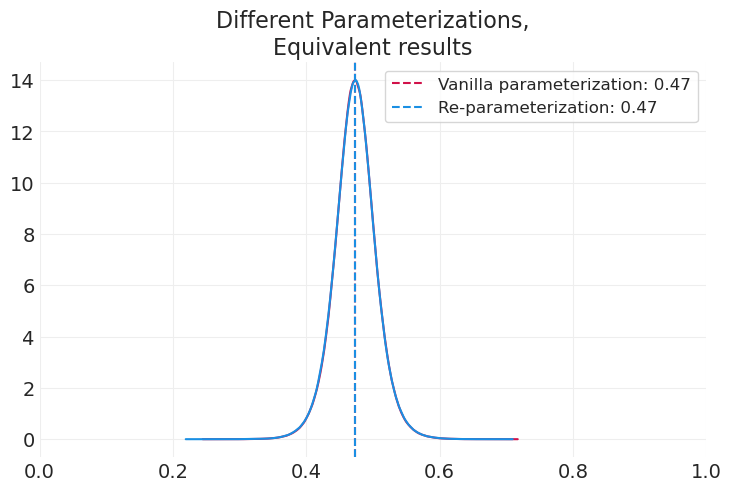

In [100]:
# Original vanilla parameterization
az.plot_dist(paternity_measurement_inference.posterior['p_father'])
p_father_mean = paternity_measurement_inference.posterior['p_father'].mean()
plt.axvline(p_father_mean, linestyle='--', label=f"Vanilla parameterization: {p_father_mean:1.2f}")

# Re-parameterization
az.plot_dist(paternity_measurement_lse_inference.posterior['p'], color='C1')
p_father_mean = paternity_measurement_lse_inference.posterior['p'].mean()
plt.axvline(p_father_mean, linestyle='--', color='C1', label=f"Re-parameterization: {p_father_mean:1.2f}")
plt.xlim([0, 1])

plt.legend()
plt.title("Different Parameterizations,\nEquivalent results");